In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from torch.utils.data import TensorDataset
from pathlib import Path
import random
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from two_spirals_utils import spiral_dataset, SpiralClassifier
from utils.utils import get_grid_predictions, create_contour_plot, resnet_CIFAR10
from utils.attacks import fgsm, pgd

import tarfile
import os

import datetime
import math


In [2]:
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: mps


## Load original CIFAR10 test images

In [3]:
# Load the CIFAR10 dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

data_orig = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

BATCH_SIZE = 1024
loader_orig = DataLoader(data_orig, batch_size=BATCH_SIZE, shuffle=False)

# CIFAR10 class labels for reference

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


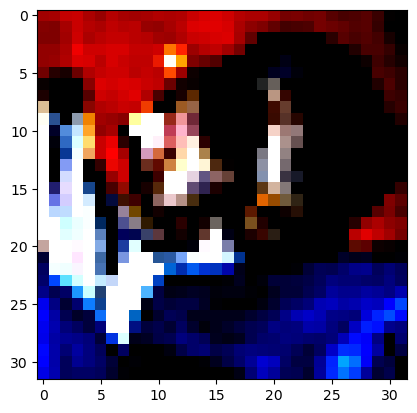

In [4]:
plt.imshow(data_orig[0][0].permute(1,2,0))

## Load pretrained classifier

In [5]:
# Assuming the checkpoint is stored at './resnet_checkpoint.pth'
checkpoint_path = '../models/resnet/resnet50_cifar10.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create an instance of the model
classifier = resnet_CIFAR10(resnet_checkpoint=checkpoint_path, device=device)

## Load mflow model

This model was trained on the 50.000 samples of the CIFAR10 train dataset. We specified a latent dimension of 500 and trained the model for 25 epochs.

In [6]:
from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform
from manifold_flow.architectures.image_transforms import create_image_transform

In [7]:
latentdim = 500
outerlayers = 20
innerlayers = 6
levels = 4
splinebins = 11
splinerange = 10.0
dropout = 0.0
actnorm = True
batchnorm = False
contextfeatures = None
linlayers = 2
linchannelfactor = 1
lineartransform = "lu"

steps_per_level = outerlayers // levels

mflow = ManifoldFlow(
        data_dim=(3, 32, 32),
        latent_dim=latentdim,
        inner_transform = create_vector_transform(
            dim = latentdim,
            flow_steps = 16 , # previously 6
            linear_transform_type = "permutation",
            base_transform_type = "rq-coupling",
            hidden_features = 100,
            num_transform_blocks = 6, #previously 2
            dropout_probability=0.0,
            use_batch_norm=False,
            num_bins=8,
            tail_bound=3,
            apply_unconditional_transform=False,
            context_features=None,
        ),
        outer_transform=create_image_transform(
            3,
            32,
            32,
            levels=4,
            hidden_channels=100,
            steps_per_level=steps_per_level,
            num_res_blocks=2,
            alpha=0.05,
            num_bits=8,
            preprocessing="glow",
            dropout_prob=dropout,
            multi_scale=True,
            num_bins=splinebins,
            tail_bound=splinerange,
            postprocessing="partial_nsf",
            postprocessing_layers=linlayers,
            postprocessing_channel_factor=linchannelfactor,
            use_actnorm=actnorm,
            use_batchnorm=batchnorm,
        )
    )

# Load model state dict on CPU
mflow.load_state_dict(torch.load("../models/cifar10_mflow/mflow_cifar10_nsamples50000_normalized_dim500_run0.pt", map_location=torch.device(device)))

<All keys matched successfully>

## Load attacked CIFAR10 dataset

In [8]:
file_path = "../data/cifar10_attacked/cifar10_pgd_eps_0.100.tar.gz"
extraction_path = "../data/cifar10_attacked/"

In [9]:
def safe_extract(member):
    print(f"Extracting: {member.name}")
    return member

try:
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path = extraction_path, members=(safe_extract(m) for m in tar.getmembers()))
except Exception as e:
    print(f"An error occurred: {e}")

Extracting: cifar10_pgd_eps_0.100.pt


/var/folders/dr/07tl1lzs7_g29ddcffd8hmr00000gn/T/ipykernel_465/2999437173.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path = extraction_path, members=(safe_extract(m) for m in tar.getmembers()))


3072


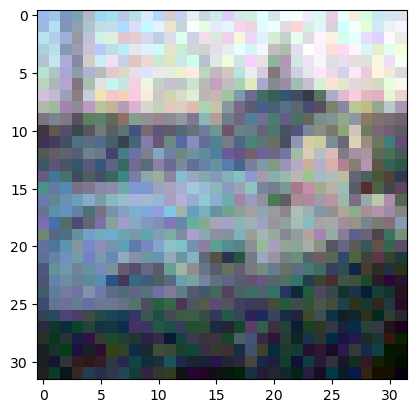

In [10]:
# Load data
idx=2
data_adv = torch.load(file_path.replace("tar.gz", "pt"), map_location=device)
loader_adv = DataLoader(data_adv, batch_size=BATCH_SIZE, shuffle=False)
print(len(data_adv))

plt.imshow(data_orig[idx][0].permute(1, 2, 0))
plt.imshow(data_adv[idx][0].permute(1, 2, 0))

## Perform inference on attacked dataset for each epsilon and visualize frequencies

In [11]:
import re
# Find out what epsilons we have
path_to_folder = '../data/cifar10_attacked/'
files = os.listdir(path_to_folder)


In [12]:
pattern = r'cifar10_pgd_eps_(\d+\.\d+).tar.gz'
numbers = []

for file in files:
    match = re.search(pattern, file)
    if match:
        number = float(match.group(1))
        numbers.append(number)

epsilons = sorted(numbers)

In [13]:
def print_with_time(message):
    current_time = datetime.datetime.now().strftime("%H:%M:%S")
    print(f"[{current_time}] {message}")

In [14]:
results    = torch.zeros(50, 4)
for idx_eps, eps in enumerate(epsilons):
    print_with_time(f"Running attacked dataset with epsilon {eps:.3f}")
    file_path = f"../data/cifar10_attacked/cifar10_pgd_eps_{eps:.3f}.tar.gz"
    extraction_path = "../data/cifar10_attacked/"

    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path = extraction_path, members=(safe_extract(m) for m in tar.getmembers()))

    total_batch_count = math.ceil(10000 / BATCH_SIZE)
    data = torch.load(file_path.replace("tar.gz", "pt"), map_location=device)
    loader_adv = DataLoader(data, batch_size=BATCH_SIZE, shuffle=False)
    
    i = 0
    for (x_adv, _), (x_orig, y_orig) in zip(loader_adv, loader_orig):
        i += 1
        print_with_time(f"Processing batch {i} of {total_batch_count}")
        # Here you can process your data, e.g., pass it through a neural network

        # Transform adversarial attack sample into latent space
        x_latent = mflow.encode(normalize(x_adv))

        # Project adversarial attack sample onto manifold
        x_proj   = mflow.decode(x_latent).detach()

        with torch.no_grad():
            pred_def = classifier(x_proj)
            pred_def = pred_def.argmax(axis=1)

            pred_orig = classifier(x_orig)
            pred_orig = pred_orig.argmax(axis=1)

            pred_adv = classifier(x_adv)
            pred_adv = pred_adv.argmax(axis=1)

        correct_preds = y_orig == pred_orig     # Mask used to filter out cases that our classifier gets wrong from the start

        att_success = pred_adv != y_orig
        def_success = pred_def == y_orig

        # Case (A)
        results[idx_eps, 0] += ((def_success & att_success) & correct_preds).sum()

        # Case (B)
        results[idx_eps, 1] += ((def_success & ~att_success) & correct_preds).sum()

        # Case (C)
        results[idx_eps, 2] += ((~def_success & att_success) & correct_preds).sum()

        # Case (D)
        results[idx_eps, 3] += ((~def_success & ~att_success) & correct_preds).sum()

        if i == 3:
            break



    # Remove .pt file, only tar.gz will remain
    os.remove(file_path.replace("tar.gz", "pt"))
    torch.save(results, f"pgd_frequency_results_checkpoint_last_eps_{eps}.pt")


torch.save(results, f"pgd_frequency_results.pt")

[09:39:42] Running attacked dataset with epsilon 0.000
Extracting: cifar10_pgd_eps_0.000.pt


/var/folders/dr/07tl1lzs7_g29ddcffd8hmr00000gn/T/ipykernel_465/2443588028.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path = extraction_path, members=(safe_extract(m) for m in tar.getmembers()))


[09:39:42] Processing batch 1 of 10
[09:43:56] Processing batch 2 of 10
[09:48:11] Processing batch 3 of 10
[09:52:21] Running attacked dataset with epsilon 0.002
Extracting: cifar10_pgd_eps_0.002.pt
[09:52:22] Processing batch 1 of 10
[09:56:29] Processing batch 2 of 10
[10:00:36] Processing batch 3 of 10
[10:04:46] Running attacked dataset with epsilon 0.004
Extracting: cifar10_pgd_eps_0.004.pt
[10:04:46] Processing batch 1 of 10
[10:08:57] Processing batch 2 of 10
[10:13:05] Processing batch 3 of 10
[10:17:08] Running attacked dataset with epsilon 0.006
Extracting: cifar10_pgd_eps_0.006.pt
[10:17:08] Processing batch 1 of 10
[10:21:13] Processing batch 2 of 10
[10:25:18] Processing batch 3 of 10
[10:29:22] Running attacked dataset with epsilon 0.008
Extracting: cifar10_pgd_eps_0.008.pt
[10:29:22] Processing batch 1 of 10
[10:33:31] Processing batch 2 of 10
[10:37:43] Processing batch 3 of 10
[10:41:55] Running attacked dataset with epsilon 0.010
Extracting: cifar10_pgd_eps_0.010.pt


In [50]:
results = torch.load(f"pgd_frequency_results.pt")
# Normalise all cases so we get probabilities that sum to 1
results /= results.sum(dim=1)[:,None]
A, B, C, D = results.T

In [35]:
idx = [0,1]

print(f"y_orig: {y_orig[idx]}")
print(f"pred_orig: {pred_orig[idx]}")
print(f"pred_adv: {pred_adv[idx]}")
print(f"pred_def: {pred_def[idx]}")

print(f"correct_preds: {correct_preds[idx]}")

print(f"successful attack: {att_success[idx]}, successful defense: {def_success[idx]}")

y_orig: tensor([8, 3])
pred_orig: tensor([8, 3])
pred_adv: tensor([8, 2])
pred_def: tensor([8, 6])
correct_preds: tensor([True, True])
successful attack: tensor([False,  True]), successful defense: tensor([ True, False])


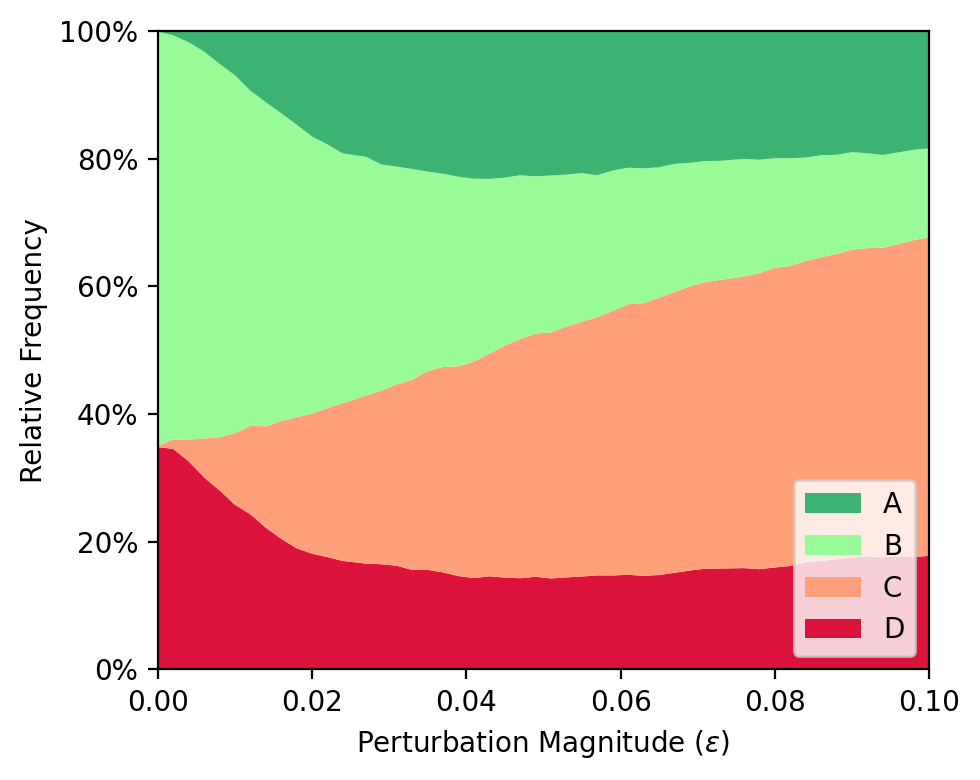

In [36]:
plt.figure(figsize=(5, 4), dpi=200)
plt.stackplot(
    epsilons, D, C, B, A,
    labels=["D", "C", "B", "A"],
    colors=["crimson", "lightsalmon", "palegreen", "mediumseagreen"]
)

# plt.title("Relative Frequency of Adversarial Defense Cases on 'Two Spirals' Dataset")
plt.xlabel(r"Perturbation Magnitude ($\epsilon$)")
plt.ylabel("Relative Frequency")
plt.legend(reverse=True, loc="lower right")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.margins(0)

plt.tight_layout()
plt.savefig(f"../figures/report/cifar10_fgsm_cases_freqs.pdf")
